In [1]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/qat/magics/install.py", line 25, in <module>
    install_qlm_magics()
  File "install.py", line 72, in qat.core.magic.install.install_qlm_magics
F

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

This Hamiltonian is analog to an antiferromagnetic coupling, which energetically benefits to anti-aligned neighbors. This is why the ground state of this Hamiltonian corresponds to a case where as many adjacent vertices as possible are in different states.

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [2]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]

# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0
    for i in range(len(edges)): # Going through the list of edges
      val += (1-2*b[edges[i][0]])*(1-2*b[edges[i][1]]) # Adding each contribution to the energy
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

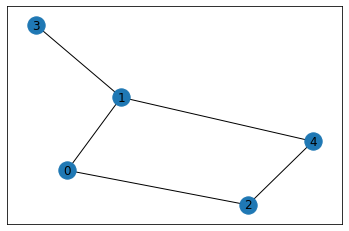

In [3]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [4]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [5]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [6]:
Z = np.array([[1,0],[0,-1]])
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for q in range(n_qubits):
      layer.apply(RX(theta),q) # First we apply RX(theta) on each qubit
    for p in range(len(edges)):
      layer.apply(U_ZZ(beta), edges[p][0], edges[p][1]) # Then, for each edge, we apply U_ZZ(beta)
    return layer


In [7]:
from qat.qpus import get_default_qpu
layer = one_qaoa_layer(5,graph6, 0.45, 0.90)
circ = layer.to_circ()  
%qatdisplay --svg circ

### Question 4

In [8]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for q in range(n_qubits):
      prog.apply(H,qubits[q])
    for l in range(n_layers):
      layer = one_qaoa_layer(n_qubits, edges, parameters[2*l], parameters[2*l+1])
      prog.apply(layer,qubits)
    
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        b = sample.state.bitstring # Getting the binary decomposition of each state of the superposition 
        val = 0
        for i in range(len(edges)): 
          val += (1-2*int(b[edges[i][0]]))*(1-2*int(b[edges[i][1]])) # Calculating the energy of each state
        obs += sample.probability*val # Calculating the mean value of the energy
    # END TODO
    return obs
    
        

In [9]:
import numpy as np
np.random.random(3)

array([0.10775799, 0.71119835, 0.55776173])

In [10]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:
We see that we need a minimum of 8 layers to reach the optimum.

0.531910449861686 -1.5293641921198609 -2.380181945565928 -2.577367926068987 -2.953102498244502 -3.366130007945415 -3.680343768459125 -4.0494660218192235 -4.259249623474323 -4.3551543941773625 -4.406500462023667 -4.44746302231502 -4.485972208113529 -4.553621864984772 -4.581893057154809 -4.618697321201812 -4.680106772194592 -4.7134896403599456 -4.726352122799056 -4.732488714980944 -4.735464480653744 -4.736057224907446 -4.736571647077085 -4.736730684297957 -4.736967319773526 -4.7371133168940895 -4.737184522666446 -4.737304914550796 -4.73751370954189 -4.73788114601458 -4.738505597470541 -4.7392105336705255 -4.7397686073155985 -4.74000096708407 -4.740010006455117 -4.740021094084579 -4.740022985786213 -4.740024616186113 -4.740025667643098 -4.74002579105636 -4.74002579295704 -4.74002579303964 0.4453868638566163 -0.33477957239094663 -0.49090500754021743 -0.9525136056966664 -1.0899298420057264 -1.9809791878073015 -2.0993241102707336 -2.2838720341736267 -2.56345287772887 -2.903289707169028 -3.57

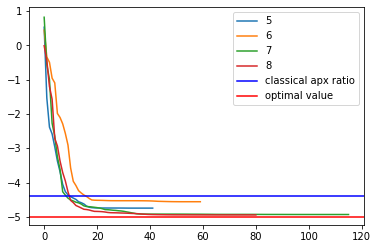

In [20]:
import matplotlib.pylab as plt


for nlayers in range(5,9,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

What we currently do in QAOA is apply the following gates at each layer :
$$  \prod_{(i,j) \in E} e^{-i \beta \sigma_i \sigma_j}  \prod_{q=1}^{n} e^{-i \theta \sigma_x^q} $$

Whereas in AQC, we write 
$$ H(s) = (1 - \frac{s}{T}) \sum_q \sigma_x^q + \frac{s}{T} \sum_{i,j\in E} \sigma_z^i \cdot \sigma_z^j$$ 

so $$ e^{-i \int_0^T H(s)ds} \simeq e^{-i\sum_{k=1}^p H(\frac{k}{p}T)\frac{T}{p}} \simeq \prod_{k=1}^p e^{-iH(\frac{k}{p}T)\frac{T}{p}}$$

Where we have used the different hypothesis given in the instruction notes.
If we identify the different $e^{-iH(\frac{k}{p}T)\frac{T}{p}}$ to the different QAOA layers, p being the number of total layers, and inject the expression of $H(s)$, we get the following form for one layer: $$e^{-i\frac{T}{p}((1 - \frac{k}{p}) \sum_q \sigma_x^q + \frac{k}{p} \sum_{i,j\in E} \sigma_z^i \cdot \sigma_z^j)} \simeq \prod_{(i,j) \in E} e^{-i \frac{Tk}{p^2} \sigma_z^i \sigma_z^j}  \prod_{q=1}^{n} e^{-i \frac{T}{p}(1-\frac{k}{p}) \sigma_x^q} $$

If we identify with the first form from QAOA, we get :$$ \theta_k = \frac{T}{p}(1-\frac{k}{p}) $$ $$\beta_k = \frac{Tk}{p^2}$$

-0.44431000691029765 -1.4626998813784315 -1.734771081134043 -2.5750630186839145 -2.7861736600657903 -3.102641612269694 -3.413938251366782 -3.657518083286716 -3.715897108411369 -3.744536134900986 -3.7990165676370165 -3.8948461434791364 -3.981971246497756 -3.9955108593641784 -4.019139661048633 -4.048386414634715 -4.051486478716898 -4.052989448200089 -4.055449406280612 -4.059144529537187 -4.064106491854013 -4.073428640171169 -4.076515231104751 -4.094263602252432 -4.20431804521317 -4.345145895157673 -4.531107628788082 -4.553772994983331 -4.5731989065713305 -4.583296750929662 -4.600720271840599 -4.623388304403954 -4.6344645381041305 -4.651857648896263 -4.674455970108461 -4.695732826779451 -4.706569335109948 -4.722381776333332 -4.734635069069103 -4.739451336533289 -4.745433712143237 -4.749544131836553 -4.75485203633146 -4.759369262038349 -4.763528911271087 -4.766832522867699 -4.771595836107023 -4.774383552275744 -4.775651503406528 -4.77605271928553 -4.776448719649851 -4.7765751375769705 -4.7

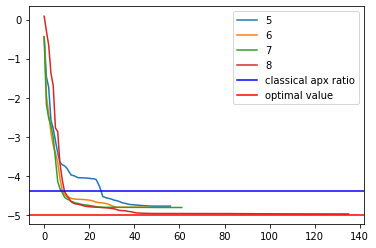

In [17]:
T = 1.

for nlayers in range(5,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(1,nlayers+1):
      parameters_init.append(T*(1-k/nlayers)/nlayers)
      parameters_init.append(T*k/(nlayers**2))
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-5.239994542416415e-05 -2.43354926628051 -2.4336018829542687 -2.5647558516787896 -3.729288192542632 -3.7724066073399376 -3.8525174667667246 -3.9930539483389906 -4.12215472261747 -4.184239428226364 -4.270640481552694 -4.369938251232703 -4.505272042286928 -4.5493219636931785 -4.603958304710758 -4.631594850537465 -4.660782425153195 -4.673335313363755 -4.679795799895908 -4.68213556967676 -4.682495708629537 -4.6830684932439 -4.6836971371389655 -4.683979093781052 -4.684087390332476 -4.684106146344081 -4.6841185646480055 -4.684127926998401 -4.684144299774147 -4.6841746130464115 -4.684401426535011 -4.684637585356231 -4.686286510426279 -4.687781485821966 -4.6896800247391095 -4.690649519899924 -4.692191127517793 -4.693675752811252 -4.69554319273106 -4.698920499183531 -4.704380432988707 -4.707885169624756 -4.713713428433349 -4.721765972418463 -4.7234553985988 -4.725749656666872 -4.7264459232039195 -4.727481316820738 -4.728656752144965 -4.730603903185504 -4.7340257039437 -4.740006565321269 -4.7492

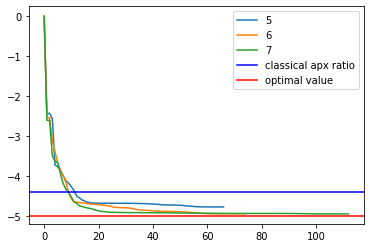

In [14]:
T = 0.01

for nlayers in range(5,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(1,nlayers+1):
      parameters_init.append(T*(1-k/nlayers)/nlayers)
      parameters_init.append(T*k/(nlayers**2))
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-3.873857731022666 -3.942649506442871 -3.9773378202661585 -4.018805683371349 -4.028237842436252 -4.040190906541919 -4.048728167140291 -4.051725953620839 -4.057073221042438 -4.065733735507249 -4.0789604218274995 -4.094418302353774 -4.115799494057435 -4.155831629017429 -4.222974472205478 -4.308448003650801 -4.336699827935756 -4.386193212431408 -4.468058927760584 -4.502585857774255 -4.52808651899966 -4.550875191153836 -4.554668680846632 -4.560802012581607 -4.5638951022021095 -4.5649253665129805 -4.565104626190034 -4.565133582513452 -4.565140807900084 -4.565142737058012 -4.565142754610483 -4.565142757032109 -4.565142758251465 -4.565142758263394 -0.24234119921096448 -1.7502310312374978 -1.910650415198086 -2.0955961530980676 -2.210228623793044 -3.1145416855876737 -3.2430705795147765 -3.639565776964119 -3.722945026854005 -3.855524182283723 -4.004300574524762 -4.184739553248271 -4.354581211078191 -4.385227772231205 -4.430505877836703 -4.445012189711475 -4.448988750847958 -4.452866664455855 -4.

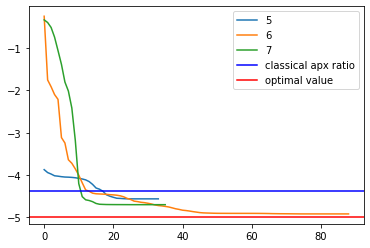

In [15]:
T = 100.

for nlayers in range(5,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(1,nlayers+1):
      parameters_init.append(T*(1-k/nlayers)/nlayers)
      parameters_init.append(T*k/(nlayers**2))
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

We observe that a low value of T seems to achieve better results. This may be an artefact because for the process to be adiabatic, the transition from one Hamiltonian to another needs to be suficiently slow.

With less layers, we see that we can still converge as fast as the regular QAOA algorithm. However, it is still quite difficult to see.